In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import os

# Shutil is a recursive tool to delete file paths
# Note: Only needed if you plan to overwrite existing filepaths
import shutil

# Function: generateData
### Performs OLS on every edge and saves a, b into csv and pickle files 

> (bool) freight : Freight mode calculation on or off  
(str) dataSourcePath : Source data file path (.xlsx)  
(str) saveFolderName : Name of the folder to save the data (non-existing)

## Note:  -1 is a dummy value (for self-loops and array padding)

In [2]:
def generateData (freight = True, dataSourcePath = 'Batch_Div27_Class8_bev_1_Results_metrics.xlsx', saveFolderName = "OLS_Data"):
    parent_dir = os.getcwd()
    savePath = os.path.join(parent_dir, saveFolderName)
    
    # If the folder already exists, remove the folder
    if os.path.exists(savePath):
        shutil.rmtree(savePath)
    os.makedirs(savePath)
    
    # Load and trim Data
    df = pd.read_excel(dataSourcePath, index_col=None, usecols=['Vehicle Model-none',\
                          'Battery Energy Consumption per Mile-kWh/mi',\
                          'Vehicle Static Mass-lbm',\
                          'Cycle Source-none',\
                          'Cargo Mass-lbm'])

    # Getting information from the dataframe
    vehicleTypes = pd.Series(df['Vehicle Model-none'].values).unique()
    
        # Function to look for the number of nodes from a list of strings in the source file
    def findNumNodes(sentence_arr):
        running_max = 1
        length = len(sentence_arr)
        i_val = np.full(length, 0)
        j_val = np.full(length, 0)
        for index, sentence in enumerate(sentence_arr):

            # Split the string, and get the corresponding node values
            temp = sentence.lower().split('div')[1].split('_raw')[0].split('_')
            j = temp[-1]
            i = temp[-2]
            j = int(''.join([x for x in j if x.isdigit()]))
            i = int(''.join([x for x in i if x.isdigit()]))
            running_max = max(i, j, running_max)
            i_val[index], j_val[index] = i, j
        return running_max, i_val, j_val
    
    # Adding "i" and "j" columns for lookup convenience later in code
    numNodes, i_val, j_val = findNumNodes(df["Cycle Source-none"].values)
    df.drop("Cycle Source-none", axis = 'columns')
    df['i'], df['j'] = i_val, j_val
    
    # Setup for csv files index and column labels
    cols = ["i_" + str(i) for i in range(1, numNodes+1)]
    rows = ["j_" + str(i) for i in range(1, numNodes+1)]
                   
    # Loop for Vehicle Types (k)
    for v in vehicleTypes:
        workFrame = df[df["Vehicle Model-none"] == v]
        newFrame = pd.DataFrame(columns = cols, index = rows)
        
        # Iterate over node values i, j, and assign constants a, b, into "newFrame"
        for i in range(1, numNodes + 1):
            for j in range(1, numNodes + 1):
                
                data = workFrame.loc[((workFrame['i'] == i) & (workFrame['j'] == j))]

                # edge case if i = j or data Doesn't exist
                if i == j :
                    newFrame.iat[i-1, j-1] = -1
                    continue
                if data.size == 0:
                    newFrame.iat[i-1, j-1] = 0
                    continue
                
                # Doing linear regression here
                if freight:
                    X = (data.loc[:, ['Cargo Mass-lbm']]*0.453592).values.reshape(-1, 1)
                else:
                    X = (data.loc[:, ['Vehicle Static Mass-lbm']]*0.453592).values.reshape(-1, 1)

                Y = (data.loc[:, ['Battery Energy Consumption per Mile-kWh/mi']]/1.60934).values.reshape(-1, 1)
                LR = LinearRegression()  # create object for the class
                LR.fit(X, Y)  # perform linear regression
                
                # Assigning the calculated a, b params
                newFrame.iat[j - 1, i - 1] = (LR.coef_.item(0), LR.intercept_.item(0))

        # Create the filePath
        tempPath2 = os.path.join(savePath, v + ".csv")
        tempPath3 = os.path.join(savePath, v + ".pkl")
        newFrame.to_csv(tempPath2)
        newFrame.to_pickle(tempPath3)

In [3]:
generateData(freight = True, dataSourcePath = 'Batch_Div27_Class8_bev_1_Results_metrics.xlsx', saveFolderName = "OLS_Data")

# Function: readData
 ### Reads the source folder generated by the  "generateData" function returns a, b, as dictionaries.
> Input:  
(str) saveFolderName: Name of source folder created by generateData
  
Output: 
>a [ k ][ i ][ j ]  
b [ k ][ i ][ j ] 


> (str) k : Vehiecle Type       
(int) i : i-node , index starts from 1  
(int) j : j-node , index starts from 1  

## Note:  -1 is a dummy value (for self-loops and array padding)

In [4]:
# Reads out the data and collects them into a dictionary.
def readDataCSV (saveFolderName = "OLS_Data"):
    
    # Initialize some folderpath
    path = os.path.join(os.getcwd(), saveFolderName)
    
    # If the folder doesn't exist, print error and return
    if not os.path.exists(path):
        print("Error, Source Folder Doesn't exist")
        return 
    VehiecleTypesPath = [ fi for fi in os.listdir(path) if fi.endswith(".pkl") ]
    VehiecleTypes = [i[:len(i) - 4] for i in VehiecleTypesPath] # change to use split or something else
    
    # Get the number of nodes brute forcedly
    filePath = os.path.join(path, VehiecleTypesPath[0])
    df = pd.read_pickle(filePath)
    numNodes = np.shape(df.iloc[:, 0].values)[0]
    
    # Initializing return dictionary
    a = {}
    b = {}

    for ind, v in enumerate(VehiecleTypes):
        filePath = os.path.join(path, v + ".pkl")
        df = pd.read_pickle(filePath)
        
        # initialize an empty array to store the days
        a[v] = np.full((numNodes + 1, numNodes + 1), -1, dtype = float)
        b[v] = np.full((numNodes + 1, numNodes + 1), -1, dtype = float)
        
        results = df.to_numpy().transpose()
        for i, temp in enumerate(results, 1):
            for j, ab in enumerate(temp, 1):
                if type(ab) == tuple:
                    a[v][i][j], b[v][i][j] = ab[0], ab[1] 
                else:
                    a[v][i][j], b[v][i][j] = ab, ab
                    
    return a, b

In [5]:
a, b = readDataCSV()

In [28]:
# Example lookup
k = 'class8_bev_2021_low_sleeper_longhaul_FU19'
i = 12
j = 4

a[k][i][j], b[k][i][j] 

(1.9736430979037362e-05, 0.8139698301604318)

# Testing (Sanity Checking)
### Performs a series of random lookup and regenerates the OLS coefficients to see if they match

In [7]:
# SET TESTING PARAMETERS HERE!!
vehiecles = ['class8_bev_2021_daycab_regionalhaul_FU19', 'class8_bev_2021_low_sleeper_longhaul_FU19']
Nodes     = 18 # Starting from 1
freight   = False

In [8]:
# Data Preparation Before Testing
dataSourcePath = 'Batch_Div27_Class8_bev_1_Results_metrics.xlsx'
workframe = pd.read_excel(dataSourcePath, index_col=None, usecols=['Vehicle Model-none',\
                          'Battery Energy Consumption per Mile-kWh/mi',\
                          'Vehicle Static Mass-lbm',\
                          'Cargo Mass-lbm',\
                          "Cycle Source-none"])

def label_ij(sentence_arr):
    length = len(sentence_arr)
    i_val = np.full(length, 0)
    j_val = np.full(length, 0)
    
    for index, sentence in enumerate(sentence_arr):
        
        # Split the string, and get the corresponding node values
        temp = sentence.lower().split('div')[1].split('_raw')[0].split('_')
        j = temp[-1]
        i = temp[-2]
        j = int(''.join([x for x in j if x.isdigit()]))
        i = int(''.join([x for x in i if x.isdigit()]))
        i_val[index], j_val[index] = i, j
    return i_val, j_val

# Adding "i" and "j" columns for lookup convenience later in code
i_val, j_val = label_ij(workframe["Cycle Source-none"].values)
workframe['i'], workframe['j'] = i_val, j_val
workframe = workframe.drop("Cycle Source-none", axis = 'columns')

# Conversions into metric
workframe["Cargo Mass-lbm"] = 0.453592 * workframe["Cargo Mass-lbm"]
workframe["Vehicle Static Mass-lbm"] = 0.453592 * workframe["Vehicle Static Mass-lbm"]
workframe['Battery Energy Consumption per Mile-kWh/mi'] = workframe['Battery Energy Consumption per Mile-kWh/mi']/1.60934
workframe = workframe.rename(columns={'Cargo Mass-lbm': 'CargoMass-kg', 'Vehicle Static Mass-lbm': 'VehicleMass-kg', 'Battery Energy Consumption per Mile-kWh/mi' : 'Energy_kwh_km'})

workframe

,Vehicle Model-none,CargoMass-kg,VehicleMass-kg,Energy_kwh_km,i,j
0,class8_bev_2021_low_sleeper_longhaul_FU19,0.000000,15897.492416,0.971320,1,2
1,class8_bev_2021_low_sleeper_longhaul_FU19,0.000000,22202.421216,1.130727,1,2
2,class8_bev_2021_low_sleeper_longhaul_FU19,3521.234696,25723.655912,1.213640,1,2
3,class8_bev_2021_low_sleeper_longhaul_FU19,7042.469392,29244.890608,1.300540,1,2
4,class8_bev_2021_low_sleeper_longhaul_FU19,10563.704088,32766.125304,1.408554,1,2
...,...,...,...,...,...,...
3666,class8_bev_2021_daycab_regionalhaul_FU19,0.000000,14924.083984,1.142187,18,17
3667,class8_bev_2021_daycab_regionalhaul_FU19,5340.592208,20265.129784,1.264910,18,17
3668,class8_bev_2021_daycab_regionalhaul_FU19,10681.638008,25605.721992,1.382916,18,17
3669,class8_bev_2021_daycab_regionalhaul_FU19,16022.230216,30946.767792,1.494577,18,17


In [18]:
# Execute functions to be tested
generateData(freight, dataSourcePath = 'Batch_Div27_Class8_bev_1_Results_metrics.xlsx', saveFolderName = "OLS_Data")
a, b = readDataCSV()

In [20]:
# Random node Testing Loop starts here

testing_count = 1000

for i in range(1, testing_count + 1):
    
    test_i = np.random.randint(1, 19)
    test_j = np.random.randint(1, 19)
    test_v = np.random.choice(vehiecles)
    
    print("Testing #" , i, "for: i=", test_i, " , j=", test_j, " , vehiecle: ",test_v)
    
    data = workframe.loc[((workframe['Vehicle Model-none'] == test_v) & (workframe['i'] == test_i) & (workframe['j'] == test_j))]
    
    # edge case if i = j or data Doesn't exist
    if test_i == test_j :
        assert a[test_v][test_i][test_j] == -1
        assert b[test_v][test_i][test_j] == -1
    else:
        # Doing linear regression here
        if freight:
            X = (data.loc[:, ["CargoMass-kg"]]).values.reshape(-1, 1)
        else:
            X = (data.loc[:, ["VehicleMass-kg"]]).values.reshape(-1, 1)
            
        Y = (data.loc[:, ['Energy_kwh_km']]).values.reshape(-1, 1)
        LR = LinearRegression()  # create object for the class
        LR.fit(X, Y)  # perform linear regression

        if a[test_v][test_i][test_j] != LR.coef_.item(0):
            print("Error: ", a[test_v][test_i][test_j], "!= ", LR.coef_.item(0))
            display(data)
            break
        if b[test_v][test_i][test_j] != LR.intercept_.item(0):
            print("Error: ", b[test_v][test_i][test_j], "!= ", LR.intercept_.item(0))
            display(data)
            break

Testing # 1 for: i= 18  , j= 7  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 2 for: i= 17  , j= 11  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 3 for: i= 14  , j= 3  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 4 for: i= 9  , j= 6  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 5 for: i= 18  , j= 13  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 6 for: i= 9  , j= 2  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 7 for: i= 13  , j= 1  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 8 for: i= 10  , j= 6  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 9 for: i= 14  , j= 9  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 10 for: i= 4  , j= 11  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 11 for: i= 1  , j= 11  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 12 for: i= 4  , j= 10  , vehiecle:  cl

Testing # 139 for: i= 7  , j= 1  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 140 for: i= 2  , j= 15  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 141 for: i= 11  , j= 14  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 142 for: i= 15  , j= 5  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 143 for: i= 9  , j= 7  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 144 for: i= 1  , j= 11  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 145 for: i= 8  , j= 11  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 146 for: i= 15  , j= 12  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 147 for: i= 18  , j= 17  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 148 for: i= 10  , j= 5  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 149 for: i= 2  , j= 5  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 150 for: i= 1  , j= 1

Testing # 236 for: i= 18  , j= 1  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 237 for: i= 6  , j= 17  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 238 for: i= 5  , j= 17  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 239 for: i= 17  , j= 15  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 240 for: i= 7  , j= 10  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 241 for: i= 14  , j= 15  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 242 for: i= 6  , j= 12  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 243 for: i= 10  , j= 6  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 244 for: i= 13  , j= 15  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 245 for: i= 8  , j= 16  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 246 for: i= 10  , j= 5  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 247 for: i= 12

Testing # 330 for: i= 7  , j= 15  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 331 for: i= 14  , j= 10  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 332 for: i= 18  , j= 7  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 333 for: i= 18  , j= 11  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 334 for: i= 17  , j= 10  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 335 for: i= 14  , j= 1  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 336 for: i= 10  , j= 13  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 337 for: i= 18  , j= 18  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 338 for: i= 11  , j= 7  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 339 for: i= 5  , j= 11  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 340 for: i= 10  , j= 13  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 341 fo

Testing # 429 for: i= 12  , j= 9  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 430 for: i= 2  , j= 9  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 431 for: i= 15  , j= 1  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 432 for: i= 17  , j= 12  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 433 for: i= 4  , j= 17  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 434 for: i= 6  , j= 14  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 435 for: i= 10  , j= 1  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 436 for: i= 10  , j= 4  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 437 for: i= 12  , j= 9  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 438 for: i= 8  , j= 4  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 439 for: i= 17  , j= 2  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 440 for: i= 13 

Testing # 524 for: i= 15  , j= 17  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 525 for: i= 3  , j= 17  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 526 for: i= 1  , j= 9  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 527 for: i= 9  , j= 15  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 528 for: i= 10  , j= 12  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 529 for: i= 1  , j= 3  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 530 for: i= 12  , j= 17  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 531 for: i= 7  , j= 14  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 532 for: i= 2  , j= 14  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 533 for: i= 8  , j= 5  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 534 for: i= 4  , j= 10  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 535 for: i= 18  , 

Testing # 618 for: i= 3  , j= 10  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 619 for: i= 14  , j= 7  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 620 for: i= 1  , j= 14  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 621 for: i= 6  , j= 18  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 622 for: i= 7  , j= 13  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 623 for: i= 18  , j= 2  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 624 for: i= 12  , j= 9  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 625 for: i= 15  , j= 6  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 626 for: i= 1  , j= 11  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 627 for: i= 14  , j= 9  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 628 for: i= 12  , j= 12  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 629 for: i= 16  

Testing # 758 for: i= 9  , j= 4  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 759 for: i= 13  , j= 11  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 760 for: i= 2  , j= 17  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 761 for: i= 10  , j= 10  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 762 for: i= 2  , j= 18  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 763 for: i= 13  , j= 2  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 764 for: i= 6  , j= 8  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 765 for: i= 1  , j= 14  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 766 for: i= 6  , j= 17  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 767 for: i= 12  , j= 17  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 768 for: i= 5  , j= 15  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 769 for: i= 5 

Testing # 892 for: i= 5  , j= 1  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 893 for: i= 8  , j= 8  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 894 for: i= 12  , j= 8  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 895 for: i= 6  , j= 5  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 896 for: i= 8  , j= 3  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 897 for: i= 11  , j= 17  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 898 for: i= 15  , j= 9  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 899 for: i= 17  , j= 11  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 900 for: i= 17  , j= 9  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 901 for: i= 5  , j= 17  , vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Testing # 902 for: i= 16  , j= 6  , vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Testing # 903 for: i= 12  , j

# Single parameters-set OLS Calculator

In [26]:
# Set parameters here to calculate OLS coefficients
vehiecles = ['class8_bev_2021_daycab_regionalhaul_FU19', 'class8_bev_2021_low_sleeper_longhaul_FU19']
vehiecle  = vehiecles[0]
i         = 1
j         = 2
freight   = False

,Vehicle Model-none,CargoMass-kg,VehicleMass-kg,Energy_kwh_km,i,j
1836,class8_bev_2021_daycab_regionalhaul_FU19,0.000000,9480.979984,0.817159,1,2
1837,class8_bev_2021_daycab_regionalhaul_FU19,0.000000,14924.083984,0.971620,1,2
1838,class8_bev_2021_daycab_regionalhaul_FU19,5340.592208,20265.129784,1.114473,1,2
1839,class8_bev_2021_daycab_regionalhaul_FU19,10681.638008,25605.721992,1.252570,1,2
1840,class8_bev_2021_daycab_regionalhaul_FU19,16022.230216,30946.767792,1.400450,1,2
1841,class8_bev_2021_daycab_regionalhaul_FU19,21363.276016,36287.360000,1.580527,1,2


a =  2.7962433960037983e-05 , b =  0.5486140329995435


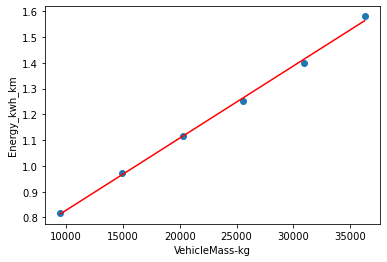

In [27]:
data = workframe.loc[((workframe['Vehicle Model-none'] == vehiecle) & (workframe['i'] == i) & (workframe['j'] == j))]

if freight:
    X = (data.loc[:, ["CargoMass-kg"]]).values.reshape(-1, 1)
    x_label = "CargoMass-kg"
else:
    X = (data.loc[:, ["VehicleMass-kg"]]).values.reshape(-1, 1)
    x_label = "VehicleMass-kg"
    
Y = (data.loc[:, ['Energy_kwh_km']]).values.reshape(-1, 1)
y_label = 'Energy_kwh_km'
LR = LinearRegression()  # create object for the class
LR.fit(X, Y)  # perform linear regression
Y_pred = LR.predict(X)  # make predictions

# Data Visualization
display(data)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel(x_label)
plt.ylabel(y_label)
print("a = ", LR.coef_.item(0), ", b = ", LR.intercept_.item(0))